In [44]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd
import sklearn

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


style.use('default')
import matplotlib.path as mpath

In [45]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['photoC_TOT_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_diat_zint','photoC_sp_zint','photoC_cocco_zint',
             'zoo1C', 'zoo2C', 'zoo3C', 'zoo4C','zoo2_TL_zavg','zoo3_TL_zavg',
             'zoo4_TL_zavg','microzoo_TL_zavg','largezoo_TL_zavg','all_zoo_TL_zavg',
            'diatC','spC','coccoC','diazC']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [46]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"])
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
photoC_TOT_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
zoo1C
zoo2C
zoo3C
zoo4C
zoo2_TL_zavg
zoo3_TL_zavg
zoo4_TL_zavg
microzoo_TL_zavg
largezoo_TL_zavg
all_zoo_TL_zavg
diatC
spC
coccoC
diazC
CPU times: user 9.01 s, sys: 2.72 s, total: 11.7 s
Wall time: 14.3 s


In [47]:
ds['zratio'] = (ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint) / ds.photoC_TOT_zint

ds['diatNPPfrac'] = (ds.photoC_diat_zint) / ds.photoC_TOT_zint

tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['HTLfood_zint'] = ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.diazC * 10.
ds['diazC_zint'] = tmp.sum(dim='z_t_150m')

In [48]:
ds

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320, time: 61, z_t: 60, z_t_150m: 15)
Coordinates:
  * time               (time) object 0001-12-31 00:00:00 ... 0061-12-31 00:00:00
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t                (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, z_t_150m
Data variables: (12/34)
    dz                 (time, z_t) float32 dask.array<chunksize=(61, 60), meta=np.ndarray>
    TAREA              (time, nlat, nlon) float64 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    KMT                (time, nlat, nlon) float64 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    photoC_TOT_zint    (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    x_graze_zoo3_zint  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    x_graze_zoo4_zint  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    ...                 ...
    zoo4C_zint         (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    HTLfood_zint       (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    diatC_zint         (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    spC_zint           (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    coccoC_zint        (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    diazC_zint         (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>

In [49]:
ds['microzoo_TL_zavg'] = microzoo_TL = (2. * ds.zoo1C_zint + ds.zoo2_TL_zavg * ds.zoo2C_zint) / (ds.zoo1C_zint + ds.zoo2C_zint)

In [50]:
ds['largezoo_TL_zavg'] = largezoo_TL = (ds.zoo3_TL_zavg * ds.zoo3C_zint + ds.zoo4_TL_zavg * ds.zoo4C_zint) / (ds.zoo3C_zint + ds.zoo4C_zint)

In [51]:
ds['all_zoo_TL_zavg'] = (2. * ds.zoo1C_zint + ds.zoo2_TL_zavg * ds.zoo2C_zint + ds.zoo3_TL_zavg * ds.zoo3C_zint + ds.zoo4_TL_zavg * ds.zoo4C_zint) / (ds.zoo1C_zint + ds.zoo2C_zint + ds.zoo3C_zint + ds.zoo4C_zint)

### update variable list

In [52]:
variables = ['zratio','HTLfood_zint','zoo4C_zint','diatC_zint','coccoC_zint','spC_zint','diazC_zint',
             'diatNPPfrac','photoC_TOT_zint','photoC_diat_zint','zoo2_TL_zavg','zoo3_TL_zavg',
             'zoo4_TL_zavg','microzoo_TL_zavg','largezoo_TL_zavg','all_zoo_TL_zavg',
             'zoo1C_zint','zoo2C_zint','zoo3C_zint','zoo4C_zint']

### trim off first 2 years since ecosystem is still adjusting (ds is now 59 years long)

In [53]:
ds = ds.isel(time=slice(2,61))

### get grid and define years

In [54]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1960,1960+tlen,1)

### detrend the dataset variables -- make anomalies

In [55]:
ds['time'] = years

In [56]:
time_3d = np.full((59,384,320),np.nan)

i = 0
for yr in years:
    time_3d[i,:,:] = yr
    i = i + 1

In [57]:
ds_anoms = xr.Dataset({v: ds[v] for v in ['time']})

In [58]:
%%time

for v in variables:
    
    print('doing variable: ',v)
    
    da = ds[v]
    model = da.polyfit("time", 1)
    
    m = model.polyfit_coefficients.sel(degree=1)
    b = model.polyfit_coefficients.sel(degree=0)
    
    predicted = m.values * time_3d + b.values
    
    ds_anoms[v] = da - predicted

doing variable:  zratio
doing variable:  HTLfood_zint
doing variable:  zoo4C_zint
doing variable:  diatC_zint
doing variable:  coccoC_zint
doing variable:  spC_zint
doing variable:  diazC_zint
doing variable:  diatNPPfrac
doing variable:  photoC_TOT_zint
doing variable:  photoC_diat_zint
doing variable:  zoo2_TL_zavg
doing variable:  zoo3_TL_zavg
doing variable:  zoo4_TL_zavg
doing variable:  microzoo_TL_zavg
doing variable:  largezoo_TL_zavg
doing variable:  all_zoo_TL_zavg
doing variable:  zoo1C_zint
doing variable:  zoo2C_zint
doing variable:  zoo3C_zint
doing variable:  zoo4C_zint
CPU times: user 3min 57s, sys: 28.7 s, total: 4min 26s
Wall time: 4min 32s


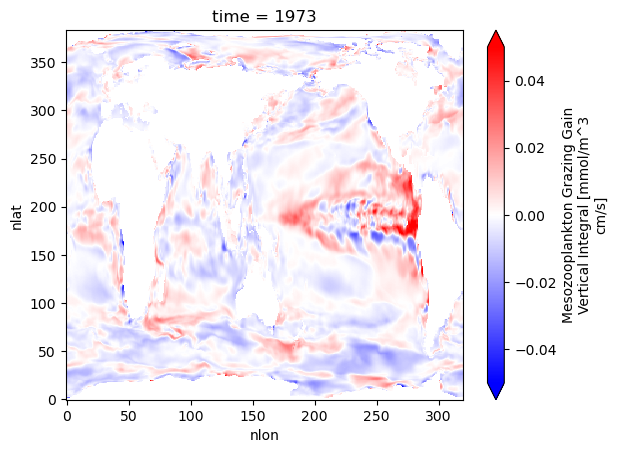

In [59]:
ds_anoms.zratio.isel(time=13).plot(vmin=-0.05,vmax=0.05,cmap='bwr')

In [60]:
years

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

### plotting function (helps with South Pole stereographic map)

In [61]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [62]:
# xvals = ds.zratio.values[:,50,50]
# yvals = ds.photoC_TOT_zint.values[:,50,50]

In [63]:
# %%time

# slope_da = np.full((384,320),np.nan)
# intercept_da = np.full((384,320),np.nan)

# for i in np.arange(0,len(lons),1):
#     for j in np.arange(0,len(lats),1):
        
#         xvals = ds.zratio.values[:,j,i]
        
#         if not np.isnan(xvals[0]):
        
#             yvals = ds.photoC_TOT_zint.values[:,j,i]

#             slope, intercept, r_value, p_value, std_err = stats.linregress(xvals,yvals)

#             slope_da[j,i] = slope
#             intercept_da[j,i] = intercept

### Do MLR in some interesting boxes

#### make longitudes that go from -180 to 180

In [64]:
lons_norm=np.full((384, 320), np.nan)

lons_norm_firstpart = lons.where(lons<=180.)
lons_norm_secpart = lons.where(lons>180.) - 360.

lons_norm_firstpart = np.asarray(lons_norm_firstpart)
lons_norm_secpart = np.asarray(lons_norm_secpart)

lons_norm[~np.isnan(lons_norm_firstpart)] = lons_norm_firstpart[~np.isnan(lons_norm_firstpart)]
lons_norm[~np.isnan(lons_norm_secpart)] = lons_norm_secpart[~np.isnan(lons_norm_secpart)]

lons_norm=xr.DataArray(lons_norm)
lons_norm=lons_norm.rename({'dim_0':'nlat'})
lons_norm=lons_norm.rename({'dim_1':'nlon'})

### Make timeseries for different boxes

In [65]:
#box #1, subtropical atlantic
box1_latmin = 15.
box1_latmax = 30.
box1_lonmin = -45.
box1_lonmax = -30.

#box #2, subantarctic SO
box2_latmin = -50.
box2_latmax = -40.
box2_lonmin = -40.
box2_lonmax = -0.

#box #3, Antarctic SO
box3_latmin = -70.
box3_latmax = -60.
box3_lonmin = -40.
box3_lonmax = -0.

In [66]:
ts_box1 = xr.Dataset({v: ds_anoms[v] for v in ['time']})

for var in variables:
    masked = ds_anoms[var].where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
    ts_box1[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

In [67]:
box1_df = pd.DataFrame()
box1_df['year'] = years

for v in variables:
    box1_df[v] = ts_box1[v]
    
box1_df.head()

,year,zratio,HTLfood_zint,zoo4C_zint,diatC_zint,coccoC_zint,spC_zint,diazC_zint,diatNPPfrac,photoC_TOT_zint,photoC_diat_zint,zoo2_TL_zavg,zoo3_TL_zavg,zoo4_TL_zavg,microzoo_TL_zavg,largezoo_TL_zavg,all_zoo_TL_zavg,zoo1C_zint,zoo2C_zint,zoo3C_zint
0,1960,-0.004930,-7.617027,-3.685227,-3.234779,-0.258678,-0.347133,0.291622,-0.029075,-0.001130,-0.001221,-0.001266,0.010364,0.010364,0.001002,0.010364,0.010204,-0.613862,-0.028426,-3.931800
1,1961,-0.003739,-5.862437,-2.415405,-3.002014,-0.273211,-0.075303,0.288455,-0.023260,-0.000726,-0.000947,0.004404,0.011237,0.011237,0.003350,0.011237,0.010371,-0.483322,-0.673049,-3.447032
2,1962,-0.001680,-4.582969,-2.475970,-0.264844,-0.012273,0.236040,0.124376,-0.006306,-0.000217,-0.000340,0.001333,-0.006721,-0.006721,-0.001722,-0.006721,-0.002020,0.103841,-1.161876,-2.106999
3,1963,0.000179,-2.029239,-1.430077,0.746435,0.017644,-0.663041,0.010726,0.002517,-0.000184,0.000060,-0.000408,-0.004980,-0.004980,-0.001788,-0.004980,-0.002937,-0.132769,-1.240644,-0.599161
4,1964,-0.002531,-2.976899,-0.768929,-2.005156,-0.170953,-0.694535,0.074386,-0.014279,-0.000900,-0.000646,-0.000704,0.008303,0.008303,-0.000036,0.008303,0.005632,-0.270787,-0.366836,-2.207970


In [68]:
ts_box2 = xr.Dataset({v: ds_anoms[v] for v in ['time']})

for var in variables:
    masked = ds_anoms[var].where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
    ts_box2[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

In [69]:
box2_df = pd.DataFrame()
box2_df['year'] = years

for v in variables:
    box2_df[v] = ts_box2[v]
    
box2_df.head()

,year,zratio,HTLfood_zint,zoo4C_zint,diatC_zint,coccoC_zint,spC_zint,diazC_zint,diatNPPfrac,photoC_TOT_zint,photoC_diat_zint,zoo2_TL_zavg,zoo3_TL_zavg,zoo4_TL_zavg,microzoo_TL_zavg,largezoo_TL_zavg,all_zoo_TL_zavg,zoo1C_zint,zoo2C_zint,zoo3C_zint
0,1960,0.004100,16.330203,-1.027407,10.114786,3.214258,-8.676702,-0.000662,0.032306,0.001184,0.002165,-0.011560,-0.003172,-0.003172,-0.015383,-0.003172,-0.011385,2.765099,-5.816337,17.357610
1,1961,0.002280,3.691987,-1.702413,6.457866,-0.258859,0.526502,0.011720,0.021078,0.001733,0.001951,-0.028123,-0.004448,-0.004448,-0.012906,-0.004448,-0.007699,-1.128432,1.453252,5.394400
2,1962,-0.005895,-6.869157,-2.990500,20.214425,0.288492,-4.395517,0.022851,0.038016,0.002522,0.003066,-0.007307,-0.001175,-0.001175,-0.003896,-0.001175,-0.000722,0.952860,-0.819385,-3.878658
3,1963,0.001486,0.437273,-2.633719,5.671978,0.906815,4.179971,0.003839,0.006246,0.002171,0.001345,-0.013351,-0.006939,-0.006939,-0.005961,-0.006939,-0.005974,-0.341340,2.280678,3.070992
4,1964,-0.004702,-0.017007,-1.872346,6.043171,4.587809,4.586067,-0.021638,0.003003,0.002319,0.001129,-0.027652,0.002426,0.002426,-0.011622,0.002426,-0.001294,-0.999268,5.227007,1.855339


In [70]:
ts_box3 = xr.Dataset({v: ds_anoms[v] for v in ['time']})

for var in variables:
    masked = ds_anoms[var].where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
    ts_box3[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

In [71]:
box3_df = pd.DataFrame()
box3_df['year'] = years

for v in variables:
    box3_df[v] = ts_box3[v]
    
box3_df.head()

,year,zratio,HTLfood_zint,zoo4C_zint,diatC_zint,coccoC_zint,spC_zint,diazC_zint,diatNPPfrac,photoC_TOT_zint,photoC_diat_zint,zoo2_TL_zavg,zoo3_TL_zavg,zoo4_TL_zavg,microzoo_TL_zavg,largezoo_TL_zavg,all_zoo_TL_zavg,zoo1C_zint,zoo2C_zint,zoo3C_zint
0,1960,0.001761,16.912949,-1.219628,25.176721,-0.006455,0.156864,-0.000045,0.058785,0.003705,0.003614,0.071276,0.014611,0.014611,0.014523,0.014611,0.013128,2.997453,0.689430,18.132577
1,1961,-0.004358,12.638755,0.936534,8.893682,0.055854,1.065797,-0.000048,0.004644,0.002155,0.001748,0.032519,0.050739,0.050739,0.008217,0.050739,0.038968,1.150643,0.333148,11.702220
2,1962,0.006154,5.045398,0.097490,7.737140,0.003845,-1.590825,-0.000052,0.038159,0.000670,0.000836,0.041613,0.055161,0.055161,0.004483,0.055161,0.041513,1.528549,-0.090250,4.947908
3,1963,0.002084,1.831054,-0.536518,-1.591945,-0.012168,-1.277758,-0.000055,0.019445,-0.000161,0.000012,-0.037311,0.005008,0.005008,-0.005825,0.005008,-0.001247,-2.377709,-0.862381,2.367572
4,1964,-0.007860,1.576697,-0.088594,12.407288,-0.014066,-0.906966,-0.000056,0.047421,0.001202,0.001377,-0.015410,0.004377,0.004377,-0.010330,0.004377,-0.000308,0.213271,-0.253304,1.665290


### visualize NPP & z-ratio correlation in each box

In [72]:
zratio_NPP_ann_corr = xr.corr(ds_anoms.zratio, ds_anoms.photoC_TOT_zint, dim='time')
zratio_NPP_ann_corr = zratio_NPP_ann_corr.squeeze()

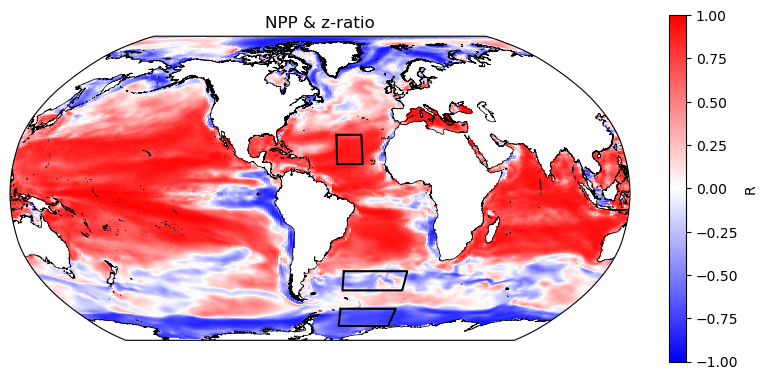

In [73]:
lon, lat, field = adjust_pop_grid(lons, lats, zratio_NPP_ann_corr)

############ make map
fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & z-ratio', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-1,vmax=1,transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# # box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='R')

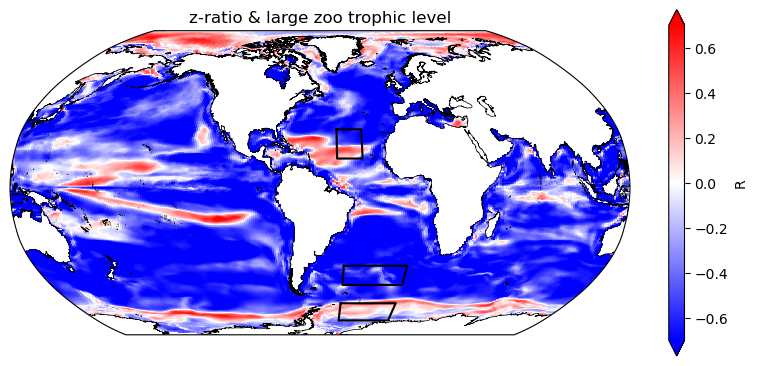

In [74]:
largezooTL_NPP_ann_corr = xr.corr(ds.zratio, ds.largezoo_TL_zavg, dim='time').squeeze()


lon, lat, field = adjust_pop_grid(lons, lats, largezooTL_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio & large zoo trophic level', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.7,vmax=0.7,transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# # box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

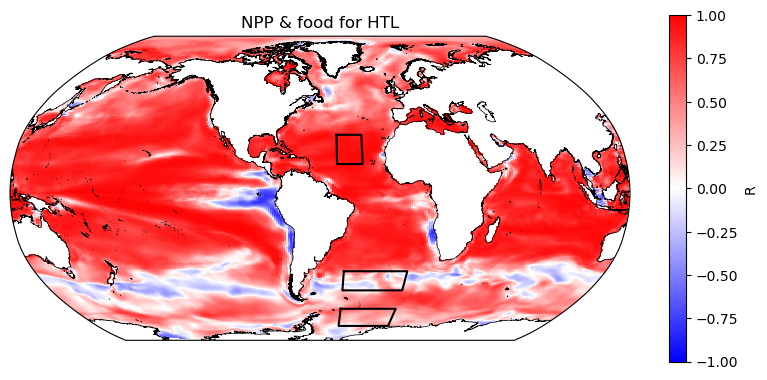

In [75]:
HTLfood_NPP_ann_corr = xr.corr(ds_anoms.HTLfood_zint, ds_anoms.photoC_TOT_zint, dim='time')
HTLfood_NPP_ann_corr = HTLfood_NPP_ann_corr.squeeze()

lon, lat, field = adjust_pop_grid(lons, lats, HTLfood_NPP_ann_corr)

############ make map
fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & food for HTL', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-1,vmax=1,transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# # box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='R')

### List of variables available for MLR

In [76]:
box1_df.columns

Index(['year', 'zratio', 'HTLfood_zint', 'zoo4C_zint', 'diatC_zint',
       'coccoC_zint', 'spC_zint', 'diazC_zint', 'diatNPPfrac',
       'photoC_TOT_zint', 'photoC_diat_zint', 'zoo2_TL_zavg', 'zoo3_TL_zavg',
       'zoo4_TL_zavg', 'microzoo_TL_zavg', 'largezoo_TL_zavg',
       'all_zoo_TL_zavg', 'zoo1C_zint', 'zoo2C_zint', 'zoo3C_zint'],
      dtype='object')

# BOX 3 (antarctic zone of Southern Ocean) multiple linear regression

### zratio as a function of NPP

In [77]:
x = box3_df[['photoC_TOT_zint']]
y = box3_df['zratio']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     29.33
Date:                Tue, 04 May 2021   Prob (F-statistic):           1.27e-06
Time:                        15:06:00   Log-Likelihood:                 219.95
No. Observations:                  59   AIC:                            -435.9
Df Residuals:                      57   BIC:                            -431.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.301e-16      0.001   1.69e-13      1.000      -0.002       0.002
photoC_TOT_zint    -4.3136      0.796     -5.416      0.000      -5.909      -2.719
==============================================================================
Omnibus:                       12.372   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.903
Skew:                           0.991   Prob(JB):                      0.00158
Kurtosis:                       4.150   Cond. No.                     1.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### z-ratio as a function of phytoplankton carbon pools

In [82]:
x = box3_df[['diatC_zint','coccoC_zint','spC_zint']] #,'diazC_zint']]
y = box3_df['zratio']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     31.29
Date:                Tue, 04 May 2021   Prob (F-statistic):           6.17e-12
Time:                        15:06:52   Log-Likelihood:                 237.08
No. Observations:                  59   AIC:                            -466.2
Df Residuals:                      55   BIC:                            -457.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.145e-17      0.001  -7.06e-14      1.000      -0.001       0.001
diatC_zint     -0.0003   9.43e-05     -3.135      0.003      -0.000      -0.000
coccoC_zint     0.1619      0.025      6.458      0.000       0.112       0.212
spC_zint       -0.0036      0.001     -5.928      0.000      -0.005      -0.002
==============================================================================
Omnibus:                        4.127   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                3.248
Skew:                           0.548   Prob(JB):                        0.197
Kurtosis:                       3.345   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### z-ratio as a function of NPP, diat NPP fraction, and large zooplankton trophic level

In [80]:
x = box3_df[['photoC_TOT_zint', 'diatNPPfrac','largezoo_TL_zavg']]
y = box3_df['zratio']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     9.957
Date:                Tue, 04 May 2021   Prob (F-statistic):           2.42e-05
Time:                        15:06:00   Log-Likelihood:                 220.50
No. Observations:                  59   AIC:                            -433.0
Df Residuals:                      55   BIC:                            -424.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               3.8e-17      0.001   4.89e-14      1.000      -0.002       0.002
photoC_TOT_zint     -4.7598      0.929     -5.122      0.000      -6.622      -2.897
diatNPPfrac          0.0418      0.042      1.004      0.320      -0.042       0.125
largezoo_TL_zavg    -0.0072      0.046     -0.157      0.876      -0.098       0.084
==============================================================================
Omnibus:                        9.760   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.326
Skew:                           0.882   Prob(JB):                      0.00944
Kurtosis:                       3.824   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### z-ratio as a function of diatC

In [81]:
x = box3_df[['diatC_zint']]
y = box3_df['zratio']

x = sm.add_constant(x)

est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     25.18
Date:                Tue, 04 May 2021   Prob (F-statistic):           5.43e-06
Time:                        15:06:00   Log-Likelihood:                 218.50
No. Observations:                  59   AIC:                            -433.0
Df Residuals:                      57   BIC:                            -428.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.203e-16      0.001   1.52e-13      1.000      -0.002       0.002
diatC_zint    -0.0006      0.000     -5.018      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       14.508   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.540
Skew:                           1.056   Prob(JB):                     0.000256
Kurtosis:                       4.507   Cond. No.                         6.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### z-ratio as a function of NPP and diatom fraction of NPP

In [164]:
x = box3_df[['photoC_TOT_zint','diatNPPfrac']]
y = box3_df['zratio']

x = sm.add_constant(x)

est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     15.19
Date:                Mon, 03 May 2021   Prob (F-statistic):           5.37e-06
Time:                        14:19:40   Log-Likelihood:                 220.49
No. Observations:                  59   AIC:                            -435.0
Df Residuals:                      56   BIC:                            -428.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.792e-17      0.001   4.92e-14      1.000      -0.002       0.002
photoC_TOT_zint    -4.7744      0.917     -5.208      0.000      -6.611      -2.938
diatNPPfrac         0.0397      0.039      1.015      0.315      -0.039       0.118
==============================================================================
Omnibus:                        9.750   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.313
Skew:                           0.885   Prob(JB):                      0.00950
Kurtosis:                       3.811   Cond. No.                     1.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### HTL food (zoo3C + zoo4C) as the dependent variable

In [165]:
x = box3_df[['diatC_zint','coccoC_zint','spC_zint']]
y = box3_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     33.30
Date:                Mon, 03 May 2021   Prob (F-statistic):           2.09e-12
Time:                        14:19:42   Log-Likelihood:                -141.17
No. Observations:                  59   AIC:                             290.3
Df Residuals:                      55   BIC:                             298.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.616e-14      0.357   1.29e-13      1.000      -0.716       0.716
diatC_zint      0.4132      0.057      7.197      0.000       0.298       0.528
coccoC_zint   129.7530     15.253      8.507      0.000      99.186     160.320
spC_zint       -1.2744      0.368     -3.466      0.001      -2.011      -0.538
==============================================================================
Omnibus:                        3.349   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                3.153
Skew:                           0.078   Prob(JB):                        0.207
Kurtosis:                       4.122   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
x = box3_df[['diatC_zint','coccoC_zint','spC_zint','photoC_TOT_zint']]
y = box3_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     34.27
Date:                Mon, 03 May 2021   Prob (F-statistic):           3.09e-14
Time:                        13:41:02   Log-Likelihood:                -134.44
No. Observations:                  59   AIC:                             278.9
Df Residuals:                      54   BIC:                             289.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.495e-15      0.321   2.02e-14      1.000      -0.645       0.645
diatC_zint         -0.2868      0.195     -1.470      0.147      -0.678       0.104
coccoC_zint       118.3222     14.072      8.408      0.000      90.110     146.535
spC_zint           -2.1054      0.399     -5.273      0.000      -2.906      -1.305
photoC_TOT_zint  5437.0063   1460.932      3.722      0.000    2508.014    8365.999
==============================================================================
Omnibus:                        1.084   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                0.461
Skew:                           0.123   Prob(JB):                        0.794
Kurtosis:                       3.356   Cond. No.                     3.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [133]:
x = box3_df[['largezoo_TL_zavg','photoC_TOT_zint']]
y = box3_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     9.399
Date:                Mon, 03 May 2021   Prob (F-statistic):           0.000302
Time:                        13:44:40   Log-Likelihood:                -163.18
No. Observations:                  59   AIC:                             332.4
Df Residuals:                      56   BIC:                             338.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.545e-13      0.514   3.01e-13      1.000      -1.029       1.029
largezoo_TL_zavg     7.6987     28.601      0.269      0.789     -49.596      64.993
photoC_TOT_zint   2257.0846    552.780      4.083      0.000    1149.734    3364.435
==============================================================================
Omnibus:                        0.759   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.684   Jarque-Bera (JB):                0.468
Skew:                           0.217   Prob(JB):                        0.792
Kurtosis:                       3.033   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [130]:
x = box3_df[['photoC_TOT_zint']]
y = box3_df['HTLfood_zint']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     19.04
Date:                Mon, 03 May 2021   Prob (F-statistic):           5.45e-05
Time:                        13:42:13   Log-Likelihood:                -163.21
No. Observations:                  59   AIC:                             330.4
Df Residuals:                      57   BIC:                             334.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.054e-13      0.510   2.07e-13      1.000      -1.020       1.020
photoC_TOT_zint  2298.3361    526.773      4.363      0.000    1243.491    3353.181
==============================================================================
Omnibus:                        0.958   Durbin-Watson:                   1.619
Prob(Omnibus):                  0.619   Jarque-Bera (JB):                0.588
Skew:                           0.242   Prob(JB):                        0.745
Kurtosis:                       3.076   Cond. No.                     1.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# BOX 2 (subantarctic Atlantic) multiple linear regression

In [140]:
x = box2_df[['photoC_TOT_zint']]
y = box2_df['zratio']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3.317
Date:                Mon, 03 May 2021   Prob (F-statistic):             0.0738
Time:                        14:11:14   Log-Likelihood:                 255.26
No. Observations:                  59   AIC:                            -506.5
Df Residuals:                      57   BIC:                            -502.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.498e-17      0.000  -3.54e-14      1.000      -0.001       0.001
photoC_TOT_zint    -0.5210      0.286     -1.821      0.074      -1.094       0.052
==============================================================================
Omnibus:                        0.122   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.230
Skew:                           0.101   Prob(JB):                        0.892
Kurtosis:                       2.770   Cond. No.                         675.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
x = box2_df[['diatC_zint','coccoC_zint','spC_zint']]
y = box2_df['zratio']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.706
Date:                Mon, 03 May 2021   Prob (F-statistic):             0.0541
Time:                        14:12:41   Log-Likelihood:                 257.65
No. Observations:                  59   AIC:                            -507.3
Df Residuals:                      55   BIC:                            -499.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.134e-18      0.000  -9.99e-15      1.000      -0.001       0.001
diatC_zint  -7.317e-05   5.46e-05     -1.339      0.186      -0.000    3.63e-05
coccoC_zint    -0.0001      0.000     -1.114      0.270      -0.000       0.000
spC_zint       -0.0002   8.33e-05     -2.596      0.012      -0.000   -4.93e-05
==============================================================================
Omnibus:                        0.772   Durbin-Watson:                   1.524
Prob(Omnibus):                  0.680   Jarque-Bera (JB):                0.234
Skew:                           0.047   Prob(JB):                        0.889
Kurtosis:                       3.294   Cond. No.                         8.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
x = box2_df[['photoC_TOT_zint','diatNPPfrac']]
y = box2_df['zratio']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     4.028
Date:                Mon, 03 May 2021   Prob (F-statistic):             0.0232
Time:                        14:13:12   Log-Likelihood:                 257.56
No. Observations:                  59   AIC:                            -509.1
Df Residuals:                      56   BIC:                            -502.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4.504e-17      0.000   -1.1e-13      1.000      -0.001       0.001
photoC_TOT_zint    -0.6399      0.283     -2.260      0.028      -1.207      -0.073
diatNPPfrac         0.0374      0.018      2.129      0.038       0.002       0.073
==============================================================================
Omnibus:                        0.008   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.996   Jarque-Bera (JB):                0.136
Skew:                          -0.022   Prob(JB):                        0.934
Kurtosis:                       2.769   Cond. No.                         689.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [148]:
x = box2_df[['largezoo_TL_zavg','photoC_TOT_zint']]
y = box2_df['zratio']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     17.55
Date:                Mon, 03 May 2021   Prob (F-statistic):           1.21e-06
Time:                        14:14:38   Log-Likelihood:                 267.95
No. Observations:                  59   AIC:                            -529.9
Df Residuals:                      56   BIC:                            -523.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -4.504e-17      0.000  -1.31e-13      1.000      -0.001       0.001
largezoo_TL_zavg    -0.4588      0.084     -5.486      0.000      -0.626      -0.291
photoC_TOT_zint     -0.9274      0.244     -3.797      0.000      -1.417      -0.438
==============================================================================
Omnibus:                        2.314   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.314   Jarque-Bera (JB):                2.147
Skew:                           0.456   Prob(JB):                        0.342
Kurtosis:                       2.797   Cond. No.                         713.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
x = box2_df[['largezoo_TL_zavg','zoo3C_zint','photoC_diat_zint']]
y = box2_df['zratio']
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
est.summary()

KeyError: "['zoo3C_zint'] not in index"

# BOX 1 (tropical Atlantic) multiple linear regression

### z-ratio as a function of NPP

In [142]:
x = box1_df[['photoC_TOT_zint']]
y = box1_df['zratio']

x = sm.add_constant(x)

est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     274.7
Date:                Mon, 03 May 2021   Prob (F-statistic):           1.84e-23
Time:                        14:12:16   Log-Likelihood:                 314.12
No. Observations:                  59   AIC:                            -624.2
Df Residuals:                      57   BIC:                            -620.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.229e-17      0.000   3.99e-13      1.000      -0.000       0.000
photoC_TOT_zint     1.6276      0.098     16.573      0.000       1.431       1.824
==============================================================================
Omnibus:                        0.094   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.954   Jarque-Bera (JB):                0.112
Skew:                          -0.080   Prob(JB):                        0.945
Kurtosis:                       2.859   Cond. No.                         629.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
x = box1_df[['diatC_zint','coccoC_zint','spC_zint','diazC_zint']]
y = box1_df['zratio']

x = sm.add_constant(x)

est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     301.2
Date:                Mon, 03 May 2021   Prob (F-statistic):           4.25e-34
Time:                        13:07:38   Log-Likelihood:                 346.48
No. Observations:                  59   AIC:                            -685.0
Df Residuals:                      55   BIC:                            -676.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.018e-17   9.19e-05   8.73e-13      1.000      -0.000       0.000
diatC_zint      0.0015    7.6e-05     19.779      0.000       0.001       0.002
coccoC_zint    -0.0023      0.001     -3.887      0.000      -0.003      -0.001
spC_zint        0.0002      0.000      1.497      0.140   -5.21e-05       0.000
==============================================================================
Omnibus:                        3.051   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.378
Skew:                           0.484   Prob(JB):                        0.305
Kurtosis:                       3.173   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
x = box1_df[['diatC_zint','spC_zint','photoC_TOT_zint']]
y = box1_df['zratio']

x = sm.add_constant(x)

est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zratio   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     521.2
Date:                Mon, 03 May 2021   Prob (F-statistic):           2.40e-40
Time:                        13:45:33   Log-Likelihood:                 361.93
No. Observations:                  59   AIC:                            -715.9
Df Residuals:                      55   BIC:                            -707.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.733e-17   7.07e-05   8.11e-13      1.000      -0.000       0.000
diatC_zint          0.0009    7.9e-05     10.853      0.000       0.001       0.001
spC_zint           -0.0007      0.000     -4.864      0.000      -0.001      -0.000
photoC_TOT_zint     1.2103      0.152      7.959      0.000       0.906       1.515
==============================================================================
Omnibus:                        0.542   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.763   Jarque-Bera (JB):                0.430
Skew:                           0.204   Prob(JB):                        0.807
Kurtosis:                       2.910   Cond. No.                     4.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### now with HTL food as the dependent variable

In [137]:
x = box1_df[['photoC_TOT_zint']]
y = box1_df['HTLfood_zint']

x = sm.add_constant(x)

est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     696.0
Date:                Mon, 03 May 2021   Prob (F-statistic):           1.24e-33
Time:                        14:01:45   Log-Likelihood:                -106.40
No. Observations:                  59   AIC:                             216.8
Df Residuals:                      57   BIC:                             221.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             5.82e-14      0.195   2.99e-13      1.000      -0.390       0.390
photoC_TOT_zint  3227.4669    122.335     26.382      0.000    2982.496    3472.438
==============================================================================
Omnibus:                        6.770   Durbin-Watson:                   1.187
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.115
Skew:                          -0.773   Prob(JB):                       0.0470
Kurtosis:                       3.316   Cond. No.                         629.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [138]:
x = box1_df[['diatC_zint','spC_zint','photoC_TOT_zint']]
y = box1_df['HTLfood_zint']

x = sm.add_constant(x)

est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     272.3
Date:                Mon, 03 May 2021   Prob (F-statistic):           5.80e-33
Time:                        14:02:00   Log-Likelihood:                -101.03
No. Observations:                  59   AIC:                             210.1
Df Residuals:                      55   BIC:                             218.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.573e-14      0.181   3.08e-13      1.000      -0.362       0.362
diatC_zint          0.4905      0.202      2.428      0.018       0.086       0.895
spC_zint           -0.3707      0.352     -1.052      0.297      -1.077       0.336
photoC_TOT_zint  2980.0943    388.889      7.663      0.000    2200.744    3759.445
==============================================================================
Omnibus:                        1.700   Durbin-Watson:                   1.456
Prob(Omnibus):                  0.427   Jarque-Bera (JB):                1.557
Skew:                          -0.387   Prob(JB):                        0.459
Kurtosis:                       2.817   Cond. No.                     4.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [139]:
x = box1_df[['diatC_zint','coccoC_zint','spC_zint']] #,'diazC_zint']]
y = box1_df['HTLfood_zint']

x = sm.add_constant(x)

est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           HTLfood_zint   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     172.7
Date:                Mon, 03 May 2021   Prob (F-statistic):           5.86e-28
Time:                        14:02:29   Log-Likelihood:                -113.41
No. Observations:                  59   AIC:                             234.8
Df Residuals:                      55   BIC:                             243.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.052e-13      0.223   4.72e-13      1.000      -0.447       0.447
diatC_zint      2.1301      0.185     11.545      0.000       1.760       2.500
coccoC_zint    -6.2738      1.412     -4.444      0.000      -9.103      -3.444
spC_zint        1.6322      0.250      6.540      0.000       1.132       2.132
==============================================================================
Omnibus:                        0.121   Durbin-Watson:                   1.436
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.152
Skew:                          -0.097   Prob(JB):                        0.927
Kurtosis:                       2.843   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### first attempts using sklearn

(it worked for finding the coefficients and intercept, but there's no statistical significance information in this package)

In [42]:
mlr = LinearRegression()

In [51]:
mlr.fit(box3_df[['photoC_TOT_zint', 'diatNPPfrac']], box3_df['zratio'])

LinearRegression()

In [52]:
mlr.intercept_

0.04099802484583573

In [53]:
mlr.coef_

array([-3.05563213,  0.06991189])